In [3]:
from scipy.stats import norm, gaussian_kde, bernoulli
from scipy.interpolate import interp1d
from scipy.optimize import basinhopping, newton
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def generate_agent_distribution(n):
    eta1 = np.random.uniform(0.01, 0.3, n).reshape(n, 1) #should change this to n x2 x1 so dont have to do as much reshaping later
    etas = np.concatenate((eta1, eta1), axis=1)
    gamma1 = np.random.uniform(1., 2., n).reshape(n, 1)
    gamma2 = np.ones((n, 1)) *100
    gammas = np.concatenate((gamma1, gamma2), axis=1)
    return etas, gammas

def compute_score_bounds(beta):
    x_box = [np.array([0., 1.]), np.array([1., 0.]), np.array([0., 0.]), np.array([1., 1.])]
    scores = [np.matmul(np.transpose(beta),x) for x in x_box]
    return min(scores), max(scores)

def func_derivative_utility(beta, s, eta, gamma, sigma):
    def f(x):
        d = x.reshape(2, 1) - eta.reshape(2, 1)
        cost_of_gaming= -2 *np.matmul(np.transpose(d), np.diag(gamma))
        score = np.matmul(np.transpose(beta), x).item()
        allocation = norm.pdf(s - score, loc=0., scale=sigma) * np.transpose(beta)
        val = cost_of_gaming + allocation
        return (cost_of_gaming + allocation).flatten()
    return f

def agent_best_response_mapping(beta, s, eta, gamma, sigma):
    x0 = np.array([0.5, 0.5])
    try:
        val = newton(func_derivative_utility(beta, s, eta, gamma, sigma), x0=x0,  maxiter=5000)
    except:
        val = eta
    val = np.clip(val, a_min=0., a_max=1.)
    return val

def compute_min_noise(gammas):
    min_eigenvalue = [min(gamma) for gamma in gammas]
    min_min_eigenvalue = min(min_eigenvalue)
    return np.sqrt(1/(2 * min_min_eigenvalue * np.sqrt(2 * np.pi * np.e)))

def quantile_best_response_distribution(beta, s, etas, gammas, sigma, score_bounds, q):
    agent_best_responses = []
    for i in range(len(etas)):
        agent_best_responses.append(agent_best_response_mapping(beta, s, etas[i], gammas[i], sigma))
    scores = [np.matmul(np.transpose(beta), x) for x in agent_best_responses]
    noises = norm.rvs(loc=0., scale=sigma, size=len(etas)).reshape(etas.shape[0], 1)
    min_score, max_score = score_bounds
    noisy_scores = np.clip(scores + noises, a_min=min_score, a_max=max_score)
    noisy_quantile = np.quantile(noisy_scores, q)
    return noisy_quantile.item()

def quantile_fixed_point(beta, etas, gammas, sigma, score_bounds, q):
    thresholds = np.linspace(score_bounds[0], score_bounds[1], 50)
    quantile_best_responses = [quantile_best_response_distribution(beta, s, etas, gammas, sigma, score_bounds, q) for s in thresholds]
    
    plt.plot(thresholds, quantile_best_responses)
    
    z = np.polyfit(thresholds.flatten(), quantile_best_responses, 3)
    f = np.poly1d(z)
    
#     f = interp1d(thresholds.flatten(), quantile_best_responses, kind="cubic")
    granular_thresholds = np.linspace(score_bounds[0], score_bounds[1], 200).flatten()
    y = f(granular_thresholds)
    plt.plot(granular_thresholds, y)
    idx = np.argmin(np.abs(granular_thresholds - y))
    noisy_fixed_point = granular_thresholds[idx]
    
    # should actually make sure that the noise being added is consistent everywhere...
    agent_best_responses = []
    for i in range(len(etas)):
        agent_best_responses.append(agent_best_response_mapping(beta, noisy_fixed_point, etas[i], gammas[i], sigma))
    scores = [np.matmul(np.transpose(beta), x) for x in agent_best_responses]
    noises = norm.rvs(loc=0., scale=sigma, size=len(etas)).reshape(etas.shape[0], 1)
    min_score, max_score = score_bounds
    noisy_scores = np.clip(scores + noises, a_min=min_score, a_max=max_score)
    plt.show()
    plt.close()
    
    return noisy_fixed_point, noisy_scores

def fixed_point_iteration(beta, s_prev, etas, gammas, sigma, score_bounds, q, plot=True):
    iterations = 50
    all_s = [s_prev]
    s= s_prev
    for k in range(iterations):
        new_s = quantile_best_response_distribution(beta, s, etas, gammas, sigma, score_bounds, q)
        all_s.append(new_s)
        s = new_s
        if plot and k % 50 == 0 and k > 0:
            plt.plot(list(range(len(all_s))), all_s)
            plt.show()
            plt.close()
    return s

def decision_maker_loss(treatments, etas, gammas, q):
    arr = np.array([1., 0.])
    arr = arr/np.sqrt(np.sum((arr ** 2)))
    true_beta = arr
    
    score_bounds = compute_score_bounds(true_beta)
    
    #etas is n x 2
    #beta is 2 x 1
    true_scores = []
    for i in range(len(etas)):
        true_scores.append(np.matmul(true_beta, etas[i]).item())
    true_scores = (np.array(true_scores).reshape(etas.shape[0], 1) - score_bounds[0])/(score_bounds[1] - score_bounds[0])
    loss_vector = (treatments - true_scores)  ** 2
    return loss_vector

In [3]:
def perturb_beta_experiment(beta, s_beta, etas, gammas, sigma, q, score_bounds, perturbation_size=0.1):
    perturbations = (2 * bernoulli.rvs(p=0.5, size=etas.shape[0] * etas.shape[1]).reshape(etas.shape) -1 ) * perturbation_size
    scores = []
    for i in range(len(etas)):
        beta_perturbed = beta + perturbations[i].reshape(etas.shape[1], 1)
        #should I project onto unit sphere??
        #norm_beta_perturbed = np.sqrt(np.sum(beta_perturbed ** 2))
        #beta_perturbed /= norm_beta_perturbed
        #print(beta_perturbed)
        agent_best_response = agent_best_response_mapping(beta_perturbed, s_beta, etas[i], gammas[i], sigma)
        scores.append(np.matmul(np.transpose(beta_perturbed), agent_best_response))
    
    noise = norm.rvs(0., scale=sigma, size=etas.shape[0]).reshape(etas.shape[0], 1)
    noisy_scores = np.clip(scores + noise, a_min=score_bounds[0], a_max=score_bounds[1])
    non_treatments = (noisy_scores <= s_beta).reshape(etas.shape[0], 1)
    treatments = (noisy_scores >= s_beta).reshape(etas.shape[0], 1)
    
    loss_vector = decision_maker_loss(treatments, etas, gammas, q)
    
    Q = np.matmul(perturbations.T, perturbations)
    gamma_loss_beta = np.linalg.solve(Q, np.matmul(perturbations.T, loss_vector))
    gamma_pi_beta = np.linalg.solve(Q, np.matmul(perturbations.T, non_treatments))
    
    return gamma_loss_beta, gamma_pi_beta


def perturb_s_beta_experiment(beta, s_beta, etas, gammas, sigma, q, score_bounds, perturbation_size=0.1):
    perturbations = (2 * bernoulli.rvs(p=0.5, size=etas.shape[0]).reshape(etas.shape[0], 1) -1 ) * perturbation_size
    scores = []
    for i in range(len(etas)):
        s_beta_perturbed = s_beta + perturbations[i]
        agent_best_response = agent_best_response_mapping(beta, s_beta_perturbed, etas[i], gammas[i], sigma)
        scores.append((np.matmul(np.transpose(beta), agent_best_response) + s_beta_perturbed).item())
    
    
    scores = np.array(scores).reshape(etas.shape[0], 1)
    noise = norm.rvs(0., scale=sigma, size=etas.shape[0]).reshape(etas.shape[0], 1)
    noisy_scores = np.clip(scores + noise, a_min=score_bounds[0], a_max=score_bounds[1])
    treatments = (noisy_scores >= s_beta).reshape(etas.shape[0], 1)
    non_treatments = (noisy_scores <= s_beta).reshape(etas.shape[0], 1)
    
    loss_vector = decision_maker_loss(treatments, etas, gammas, 1)
    
    Q = np.matmul(perturbations.T, perturbations)
    gamma_loss_s = Q/np.matmul(perturbations.T, loss_vector) 
    gamma_pi_s = Q/(np.matmul(perturbations.T, non_treatments) + 1e-5)
    return gamma_loss_s, gamma_pi_s

In [4]:
def density_estimate(arr, x):
    kernel = gaussian_kde(arr.flatten())
    return kernel(x)

In [7]:
def run_full_game(n, q, maxiter, learning_rate):
    beta = np.array([np.sin(np.pi/4), np.sin(np.pi/4)]).reshape(2, 1)
    losses = []
    
    beta1s = []
    beta2s = []
    for i in range(maxiter):
        score_bounds = compute_score_bounds(beta)
        etas, gammas = generate_agent_distribution(n)
        sigma = compute_min_noise(gammas)
        
        
        print("Beta:{}".format(beta))
        print("Generating fixed point...")
        #s_beta = fixed_point_iteration(beta, s_prev, etas, gammas, sigma, score_bounds, q)
        s_beta, noisy_scores = quantile_fixed_point(beta, etas, gammas, sigma, score_bounds, q)
        print("FP: {}".format(s_beta))

        treatments = (noisy_scores >= s_beta).reshape(etas.shape[0], 1)
        loss = np.sqrt(np.sum(decision_maker_loss(treatments, etas, gammas, q)))
        deriv_loss_beta, deriv_pi_beta = perturb_beta_experiment(beta, s_beta, etas, gammas, sigma,q, score_bounds)
        deriv_loss_s, deriv_pi_s = perturb_s_beta_experiment(beta, s_beta, etas, gammas, sigma, q, score_bounds)
        
        density_value = density_estimate(noisy_scores, s_beta)
        print("Density value:{}".format( density_value))
        deriv_s_beta = -(1/(density_value + deriv_pi_s) ) * deriv_pi_beta

        total_deriv = deriv_loss_beta #+ deriv_loss_s * deriv_s_beta
        new_beta = beta - learning_rate * total_deriv

        norm_new_beta = np.sqrt(np.sum(new_beta ** 2))
        beta = new_beta/norm_new_beta
        s_prev = s_beta
        losses.append(loss)
        print("Loss: {}".format(loss))
        beta1s.append(beta[0])
        beta2s.append(beta[1])
    
    return losses, beta, beta1s, beta2s
        
        
        
        

Beta:[[0.70710678]
 [0.70710678]]
Generating fixed point...


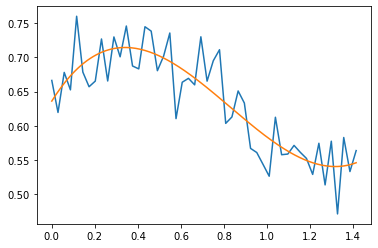

FP: 0.6680204766988489
Density value:[0.95993206]
Loss: 5.684384491259124
Beta:[[0.6920606 ]
 [0.72183941]]
Generating fixed point...


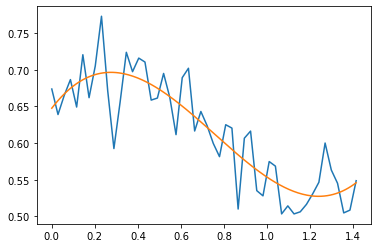

FP: 0.6394522633281055
Density value:[0.91690811]
Loss: 5.673804302009905
Beta:[[0.68033492]
 [0.73290136]]
Generating fixed point...


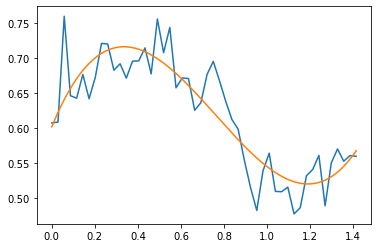

FP: 0.6533554639099509
Density value:[0.72247309]
Loss: 5.536064456130859
Beta:[[0.6769572 ]
 [0.73602239]]
Generating fixed point...


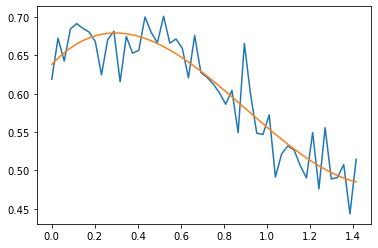

FP: 0.6390359925229396
Density value:[0.77643729]
Loss: 5.371977582906643
Beta:[[0.67022718]
 [0.742156  ]]
Generating fixed point...


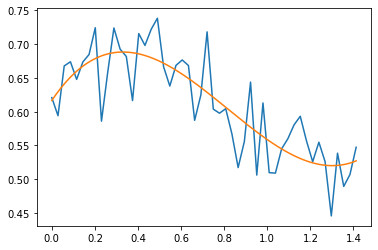

FP: 0.6458636650281877
Density value:[0.71803365]
Loss: 5.179398687205583
Beta:[[0.66863362]
 [0.74359202]]
Generating fixed point...


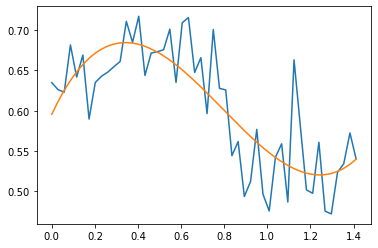

FP: 0.6386950097986688
Density value:[0.75032062]
Loss: 5.563935787693846
Beta:[[0.64650241]
 [0.76291194]]
Generating fixed point...


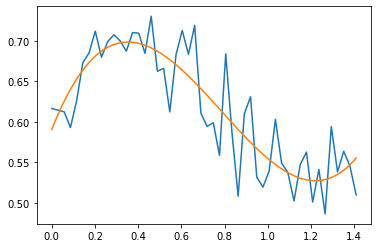

FP: 0.6515885457607469
Density value:[0.70414957]
Loss: 5.28872770295742
Beta:[[0.6414191 ]
 [0.76719068]]
Generating fixed point...


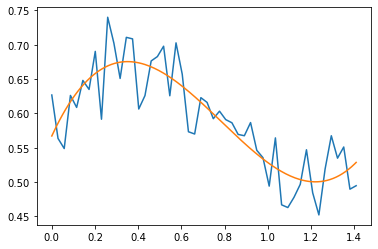

FP: 0.6299812580216249
Density value:[0.86475776]
Loss: 6.115076600112964
Beta:[[0.63346784]
 [0.77376902]]
Generating fixed point...


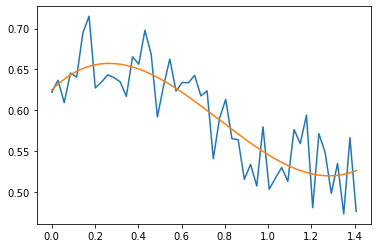

FP: 0.622295696557211
Density value:[0.759612]
Loss: 6.084286334589756
Beta:[[0.61480411]
 [0.78867985]]
Generating fixed point...


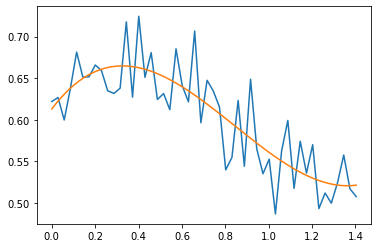

FP: 0.6347414893640074
Density value:[0.70945248]
Loss: 5.9612746658847495
Beta:[[0.60581527]
 [0.79560534]]
Generating fixed point...


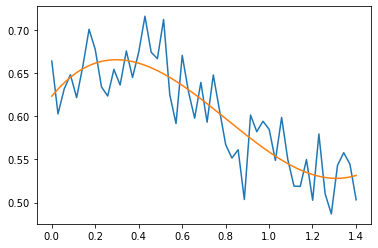

FP: 0.633808316294079
Density value:[0.60703728]
Loss: 5.151481118031172
Beta:[[0.5984203 ]
 [0.80118234]]
Generating fixed point...


In [ ]:
losses, final_beta, beta1s, beta2s = run_full_game(n=200, q=0.8, maxiter=100, learning_rate=0.05)


In [ ]:
plt.plot(list(range(len(losses))), losses)

In [ ]:
plt.plot(list(range(len(beta1s))), beta1s)

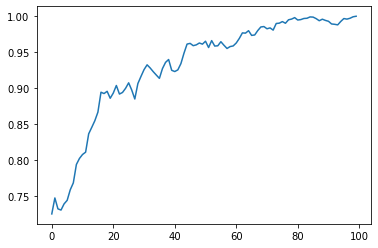

In [11]:
plt.plot(list(range(len(beta2s))), beta2s)

Testing functionality

In [ ]:
etas = np.array([0.5, 0.5]).reshape(1, 2)
gammas = np.array([[10., 10.]]).reshape(1, 2)
beta = np.array([np.sin(0.5), np.cos(0.5)]).reshape(2, 1)
min_score, max_score = compute_score_bounds(beta)
thresholds = np.linspace(min_score, max_score, 50)
sigma = compute_min_noise(gammas)

best_responses = [agent_best_response_mapping(beta, s, etas[0], gammas[0], sigma) for s in thresholds]

scores = [np.matmul(np.transpose(beta), x) for x in best_responses]
plt.plot(thresholds, scores)
plt.plot(thresholds, thresholds)

In [7]:
thetas = np.linspace(0., 2 * np.pi, 10)
etas, gammas = generate_agent_distribution(50)
sigma = compute_min_noise(gammas)
fp = []
for theta in thetas:
    beta = np.array([np.sin(theta), np.cos(theta)])
    score_bounds_beta = compute_score_bounds(beta)

    fp.append(quantile_fixed_point(beta, etas, gammas, sigma, score_bounds_beta, q))
    
plt.plot(thetas, fp)

NameError: name 'q' is not defined

In [ ]:

#     eta1 = np.tile(np.array([[0.6, 0.8]]), (int(n/2), 1))
#     eta2 = np.tile(np.array([[0.1, 0.3]]), (int(n/2), 1))
#     gamma1 = np.tile(np.array([1., 1.]), (int(n/2), 1))
#     gamma2 = np.tile(np.array([1., 1.]), (int(n/2), 1))
    
#     etas = np.vstack((eta1, eta2))
#     gammas = np.vstack((gamma1, gamma2))

eta1 = np.tile(np.array([[0.6, 0.8]]), (int(10/2), 1))
eta2 = np.tile(np.array([[0.1, 0.3]]), (int(10/2), 1))
np.vstack((eta1, eta2))